PROJET_DIT


Chargement des packages

In [1]:

# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
import joblib # Pour stocker le modèle
from sklearn.ensemble import RandomForestClassifier

Base de données insecurite alimentaire

Importation et nettoyage des données

In [2]:



data = pd.read_excel("D:/PROJET_DIT-20250506T153458Z-001/MES_PROJETS/model/data/DDDIEMMME.xlsx", sheet_name="Feuil2")

# Aperçu des données
print("Aperçu des données :")
#print(data.head())


Aperçu des données :


In [3]:
import numpy as np
# 1. Vérifier les valeurs manquantes
print("Valeurs manquantes avant nettoyage:")
print(data.isnull().sum())

Valeurs manquantes avant nettoyage:
id                                                              7759
q100_region                                                     7759
q101_departement                                                7759
q114_1_situation_matrimoniale_cm                                7765
q115_1_cm_souffre_t_il_maladie_chronique                        7765
                                                                ... 
q603_sauter_un_repas                                            7864
q604_manger_moins_que_ce_que_vous_auriez_du                     7894
q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent    7863
q606_1_avoir_faim_mais_ne_pas_manger                            7867
q607_1_passer_toute_une_journee_sans_manger                     7790
Length: 98, dtype: int64


In [4]:
# Remplacer les valeurs manquantes par la médiane
# pour les colonnes numériques uniquement
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())


In [5]:
# 2. Suppression des doublons
print(f"Nombre de doublons avant suppression: {data.duplicated().sum()}")
data.drop_duplicates(inplace=True)

Nombre de doublons avant suppression: 7518


In [7]:
# 3. Traitement des valeurs aberrantes
# Remplacer les valeurs aberrantes par la médiane ou les supprimer
import numpy as np

for colonne in data.select_dtypes(include=np.number).columns:
    seuil_min, seuil_max = data[colonne].quantile(0.05), data[colonne].quantile(0.95)
    data[colonne] = np.where((data[colonne] < seuil_min) | (data[colonne] > seuil_max),
                             data[colonne].median(),
                             data[colonne])


In [ ]:
data.shape

NORMALISATION DES VARIABLE NUMERIQUE

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:  # Sélectionner les colonnes non numériques
    # Convert the column to string type before applying LabelEncoder
    data[col] = data[col].astype(str)
    data[col] = label_encoder.fit_transform(data[col])

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Appliquer OneHotEncoder
# Replace 'sparse' with 'sparse_output'
from sklearn.preprocessing import OneHotEncoder

# Appliquer OneHotEncoder
# Replace 'sparse' with 'sparse_output'
one_hot_encoder = OneHotEncoder(sparse_output=False)
data_encoded = one_hot_encoder.fit_transform(data.select_dtypes(include=['object']))
data_encoded = pd.DataFrame(data_encoded, columns=one_hot_encoder.get_feature_names_out(data.select_dtypes(include=['object']).columns))

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[data.select_dtypes(include=['float', 'int']).columns] = scaler.fit_transform(data.select_dtypes(include=['float', 'int']))


In [11]:
# Enregistrer le dataset encodé
chemin_projet = "D:/PROJET_DIT-20250506T153458Z-001/MES_PROJETS/"  # Remplacez par le chemin de votre répertoire
data.to_csv(chemin_projet + "data_encoded_1.csv", index=False)

print("Le fichier a été enregistré avec succès dans le répertoire de votre projet.")



Le fichier a été enregistré avec succès dans le répertoire de votre projet.


In [12]:
import pandas as pd

# Charger le fichier encodé
chemin_projet = "D:/PROJET_DIT-20250506T153458Z-001/MES_PROJETS/"
data_encoded = pd.read_csv(chemin_projet + "data_encoded_1.csv")

# Vérification rapide
print("Aperçu du fichier encodé :")
#print(data_encoded.head())
#print("Colonnes disponibles :", data_encoded.columns)

Aperçu du fichier encodé :


In [ ]:
data_encoded.shape

In [13]:
import pandas as pd

# Étape 1 : Définir la variable cible 'insécurité_alimentaire'
def definir_insécurité_alimentaire(row):
    # Insécurité sévère : au moins 1 privation critique avec score > 1.5
    if sum(row[col] > 1.5 for col in [
        'q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent',
        'q606_1_avoir_faim_mais_ne_pas_manger',
        'q607_1_passer_toute_une_journee_sans_manger'
    ]) >= 1:
        return 2
    # Insécurité modérée : au moins 2 privations légères/modérées avec score entre 0 et 1.5
    elif sum(0 < row[col] <= 1.5 for col in [
        'q600_inquiets_de_ne_pas_avoir_suffisamment_de_nourriture',
        'q601_ne_pas_manger_nourriture_saine_nutritive',
        'q602_manger_nourriture_peu_variee',
        'q603_sauter_un_repas',
        'q604_manger_moins_que_ce_que_vous_auriez_du'
    ]) >= 2:
        return 1
    # Aucune insécurité
    else:
        return 0



 PREPARATION DES DONNEES POUR LE MODELE

In [14]:
# Étape 2 : Appliquer la fonction au DataFrame encodé
data['insécurité_alimentaire'] = data_encoded.apply(definir_insécurité_alimentaire, axis=1)

# Étape 3 : Filtrer les cas modérés ou sévères
data_filtrée = data[data['insécurité_alimentaire'].isin([1, 2])]
data_encoded_filtré = data_encoded.loc[data_filtrée.index]  # Garder les mêmes lignes dans le dataset encodé

# Étape 4 : Calculer les corrélations avec la variable cible
data_encoded_filtré['insécurité_alimentaire'] = data_filtrée['insécurité_alimentaire']  # Ajouter la cible
correlations = data_encoded_filtré.corr()

# Étape 5 : Sélectionner les 10 variables les plus corrélées
top_features = correlations['insécurité_alimentaire'].abs().sort_values(ascending=False).iloc[1:11]
print("🔍 Les 10 variables les plus corrélées :")
print(top_features)

# Étape 6 : Créer un nouveau dataset avec ces variables + la cible
top_features_names = top_features.index.tolist()
data_reduced = data_encoded_filtré[top_features_names + ['insécurité_alimentaire']]
print("📊 Nouveau dataset réduit :")
#print(data_reduced.head())


🔍 Les 10 variables les plus corrélées :
q606_1_avoir_faim_mais_ne_pas_manger                            0.779630
q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent    0.775247
q604_manger_moins_que_ce_que_vous_auriez_du                     0.680129
q607_1_passer_toute_une_journee_sans_manger                     0.630765
q603_sauter_un_repas                                            0.625893
q207_1_principale_source_energie_cuisson                        0.617320
PRATIQUE_PECHE                                                  0.550865
q602_manger_nourriture_peu_variee                               0.471341
q601_ne_pas_manger_nourriture_saine_nutritive                   0.442618
MILIEU_RESIDENCE                                                0.435433
Name: insécurité_alimentaire, dtype: float64
📊 Nouveau dataset réduit :


In [15]:
# Variables explicatives (features) et cible (target)
X = data_reduced.drop(columns=['insécurité_alimentaire'])  # Toutes les colonnes sauf la cible
y = data_reduced['insécurité_alimentaire']  # La variable cible # C

DIVISION EN TRAIN TEST DU DATASET

In [16]:
from sklearn.model_selection import train_test_split

# Division 80% entraînement, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles
print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)


Taille de l'ensemble d'entraînement : (1946, 10)
Taille de l'ensemble de test : (487, 10)


In [17]:
# Remapping des classes : 1 → 0 (modérée), 2 → 1 (sévère)
y_train_mapped = y_train.replace({1: 0, 2: 1})
y_test_mapped = y_test.replace({1: 0, 2: 1})


ENTRAINEMENT 1 DU MODELE

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# 🔁 Modèle de base
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train_mapped)

# 🔍 Étape 1 : extraire les importances
importances = rf.feature_importances_
feature_names = X_train.columns

# 🔍 Étape 2 : sélectionner les 5 variables les plus importantes
indices_top5 = np.argsort(importances)[-5:]  # indices des 5 plus importantes
selected_features = feature_names[indices_top5]

print("✅ 5 variables sélectionnées :", selected_features.tolist())

# ✅ Étape 3 : reconstruire les DataFrames
X_train_selected_df = X_train[selected_features]
X_test_selected_df = X_test[selected_features]

# 🔁 Réentraînement avec les 5 variables
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected_df, y_train_mapped)
preds = rf_selected.predict(X_test_selected_df)

# 📊 Évaluation
print("📊 Rapport après sélection des 5 features :")
print(classification_report(y_test_mapped, preds))

# 🔍 Validation croisée
cv_scores = cross_val_score(rf_selected, X_train_selected_df, y_train_mapped, cv=5, scoring='accuracy')
print(f"✅ Score moyen CV (Random Forest 5 features) : {cv_scores.mean():.4f}")


✅ 5 variables sélectionnées : ['q601_ne_pas_manger_nourriture_saine_nutritive', 'q603_sauter_un_repas', 'q604_manger_moins_que_ce_que_vous_auriez_du', 'q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent', 'q606_1_avoir_faim_mais_ne_pas_manger']
📊 Rapport après sélection des 5 features :
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       442
         1.0       1.00      0.93      0.97        45

    accuracy                           0.99       487
   macro avg       1.00      0.97      0.98       487
weighted avg       0.99      0.99      0.99       487

✅ Score moyen CV (Random Forest 5 features) : 0.9938


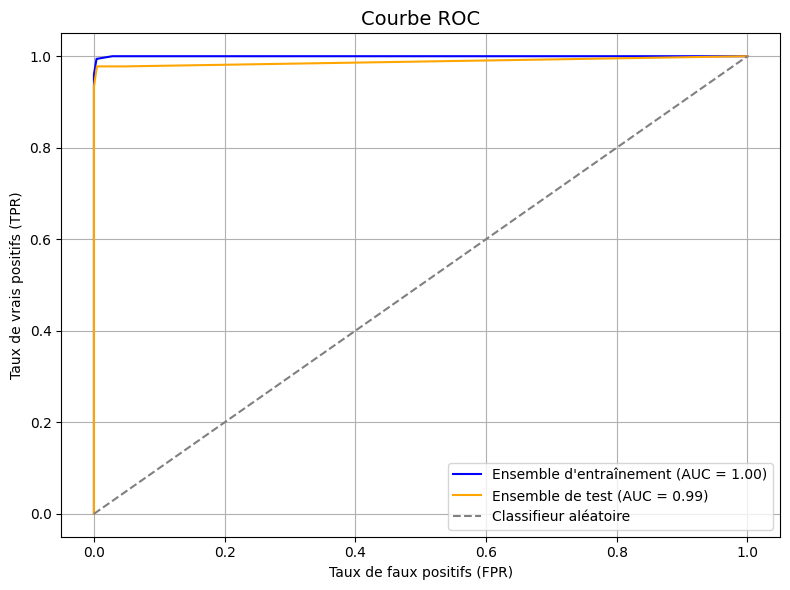

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Prédictions des probabilités
y_train_proba = rf_selected.predict_proba(X_train_selected_df)[:, 1]
y_test_proba = rf_selected.predict_proba(X_test_selected_df)[:, 1]

# Courbes ROC
fpr_train, tpr_train, _ = roc_curve(y_train_mapped, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_mapped, y_test_proba)

# AUC
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# 🎨 Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Ensemble d'entraînement (AUC = {auc_train:.2f})", color='blue')
plt.plot(fpr_test, tpr_test, label=f"Ensemble de test (AUC = {auc_test:.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Classifieur aléatoire')

plt.title("Courbe ROC", fontsize=14)
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


ENTRAINEMENT 2 DU MODELE

d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:35:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


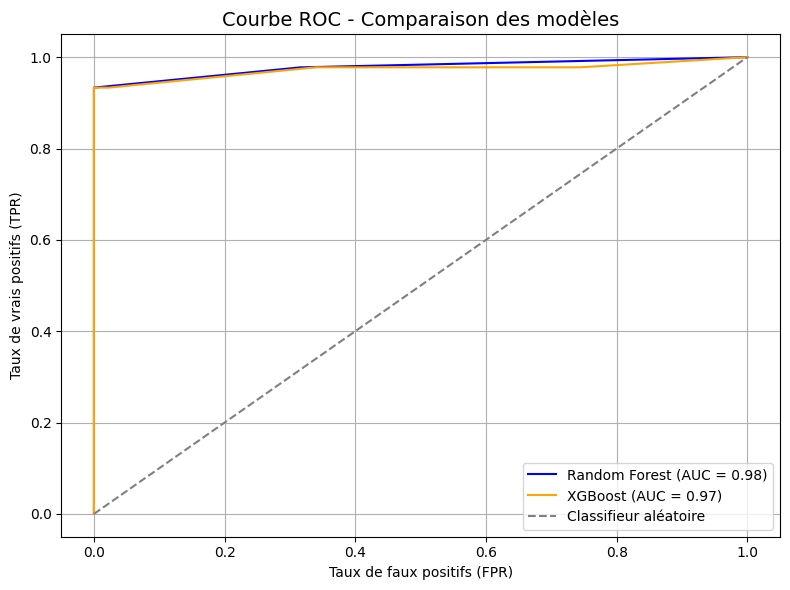

📊 Rapport Random Forest :
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       442
         1.0       1.00      0.93      0.97        45

    accuracy                           0.99       487
   macro avg       1.00      0.97      0.98       487
weighted avg       0.99      0.99      0.99       487

📊 Rapport XGBoost :
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       442
         1.0       1.00      0.93      0.97        45

    accuracy                           0.99       487
   macro avg       1.00      0.97      0.98       487
weighted avg       0.99      0.99      0.99       487



d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:

✅ Score moyen AUC CV - Random Forest : 0.9897
✅ Score moyen AUC CV - XGBoost       : 0.9926


d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [22:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score

# 🔹 Modèle initial pour la sélection de features
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf_base.fit(X_train, y_train_mapped)

# 🔹 Sélection des features importantes
selector = SelectFromModel(rf_base, threshold=None, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


# 🔍 Récupération des noms des features sélectionnées
selected_mask = selector.get_support()
feature_names_rf = X_train.columns[selected_mask].tolist()

# 🧪 Reconstruction de X_test avec les noms des features
X_test_rf = X_test[feature_names_rf].values

# 🔹 Modèle 1 : Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train_mapped)
rf_preds = rf_model.predict(X_test_selected)
rf_proba = rf_model.predict_proba(X_test_selected)[:, 1]

# 🔹 Modèle 2 : XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_selected, y_train_mapped)
xgb_preds = xgb_model.predict(X_test_selected)
xgb_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

# 🔹 Courbes ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test_mapped, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_mapped, xgb_proba)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# 🔹 Affichage ROC comparatif
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Classifieur aléatoire')

plt.title("Courbe ROC - Comparaison des modèles", fontsize=14)
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Évaluation textuelle
print("📊 Rapport Random Forest :")
print(classification_report(y_test_mapped, rf_preds))

print("📊 Rapport XGBoost :")
print(classification_report(y_test_mapped, xgb_preds))

# 🔹 Validation croisée
rf_cv = cross_val_score(rf_model, X_train_selected, y_train_mapped, cv=5, scoring='roc_auc')
xgb_cv = cross_val_score(xgb_model, X_train_selected, y_train_mapped, cv=5, scoring='roc_auc')

print(f"✅ Score moyen AUC CV - Random Forest : {rf_cv.mean():.4f}")
print(f"✅ Score moyen AUC CV - XGBoost       : {xgb_cv.mean():.4f}")


In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
import pandas as pd

# 🔹 Prédictions sur l'ensemble d'entraînement
rf_train_pred = rf_model.predict(X_train_selected)
xgb_train_pred = xgb_model.predict(X_train_selected)

# 🔹 Calcul des métriques pour Random Forest
rf_metrics = {
    'Accuracy': [accuracy_score(y_train_mapped, rf_train_pred), accuracy_score(y_test_mapped, rf_preds)],
    'AUC': [roc_auc_score(y_train_mapped, rf_train_pred), roc_auc_score(y_test_mapped, rf_preds)],
    'Recall': [recall_score(y_train_mapped, rf_train_pred), recall_score(y_test_mapped, rf_preds)]
}

# 🔹 Calcul des métriques pour XGBoost
xgb_metrics = {
    'Accuracy': [accuracy_score(y_train_mapped, xgb_train_pred), accuracy_score(y_test_mapped, xgb_preds)],
    'AUC': [roc_auc_score(y_train_mapped, xgb_train_pred), roc_auc_score(y_test_mapped, xgb_preds)],
    'Recall': [recall_score(y_train_mapped, xgb_train_pred), recall_score(y_test_mapped, xgb_preds)]
}

# 🔹 Création des tableaux
# 🔹 Tableau Random Forest
rf_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall'],
    'Train': [
        accuracy_score(y_train_mapped, rf_train_pred),
        roc_auc_score(y_train_mapped, rf_train_pred),
        recall_score(y_train_mapped, rf_train_pred)
    ],
    'Test': [
        accuracy_score(y_test_mapped, rf_preds),
        roc_auc_score(y_test_mapped, rf_preds),
        recall_score(y_test_mapped, rf_preds)
    ]
})

# 🔹 Tableau XGBoost
xgb_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall'],
    'Train': [
        accuracy_score(y_train_mapped, xgb_train_pred),
        roc_auc_score(y_train_mapped, xgb_train_pred),
        recall_score(y_train_mapped, xgb_train_pred)
    ],
    'Test': [
        accuracy_score(y_test_mapped, xgb_preds),
        roc_auc_score(y_test_mapped, xgb_preds),
        recall_score(y_test_mapped, xgb_preds)
    ]
})

# 🔹 Affichage
print("\n📋 Performance - Random Forest")
print(rf_table)

print("\n📋 Performance - XGBoost")
print(xgb_table)




📋 Performance - Random Forest
   Métrique     Train      Test
0  Accuracy  0.995889  0.993840
1       AUC  0.977143  0.966667
2    Recall  0.954286  0.933333

📋 Performance - XGBoost
   Métrique     Train      Test
0  Accuracy  0.995889  0.993840
1       AUC  0.977143  0.966667
2    Recall  0.954286  0.933333


In [22]:
X_test_rf = X_test[feature_names_rf]
rf_preds = rf_model.predict(X_test_rf)
print(rf_preds)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.

d:\PROJET_DIT-20250506T153458Z-001\MES_PROJETS\DIEMMME\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Prédiction sur les bases train et test

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

# Prédire les classes sur les ensembles d'entraînement et de test
y_train_pred = rf_model.predict(X_train_selected)
y_test_pred = rf_model.predict(X_test_selected)

Performances du modèle

In [24]:
# Calculer les mesures de performance
train_accuracy = accuracy_score(y_train_mapped, y_train_pred)
test_accuracy = accuracy_score(y_test_mapped, y_test_pred)
train_auc = roc_auc_score(y_train_mapped, y_train_pred)
test_auc = roc_auc_score(y_test_mapped, y_test_pred)
train_recall = recall_score(y_train_mapped, y_train_pred)
test_recall = recall_score(y_test_mapped, y_test_pred)

# Créer le tableau d'évaluation des performances
performance_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall'],
    'Ensemble d\'entraînement': [train_accuracy, train_auc, train_recall],
    'Ensemble de test': [test_accuracy, test_auc, test_recall]
})

# Afficher le tableau d'évaluation des performances
print(performance_table)

   Métrique  Ensemble d'entraînement  Ensemble de test
0  Accuracy                 0.995889          0.993840
1       AUC                 0.977143          0.966667
2    Recall                 0.954286          0.933333


In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_train_selected, y_train_mapped, cv=5, scoring='f1')
print(f"F1 scores par fold : {scores}")
print(f"F1 moyen : {scores.mean():.4f} ± {scores.std():.4f}")


F1 scores par fold : [0.98550725 0.97058824 0.97142857 0.95522388 0.97058824]
F1 moyen : 0.9707 ± 0.0096


DEPLOIMENT DU MODELE

In [26]:
import joblib
joblib.dump(rf_model, "modele_food_insecurity.pkl")
joblib.dump(xgb_model, "modele_food_insecurity_xgb1.pkl")
# Enregistrement du modèle avec joblib

['modele_food_insecurity_xgb1.pkl']

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Remapping des classes
y_train_mapped = y_train.replace({1: 0, 2: 1})
y_test_mapped = y_test.replace({1: 0, 2: 1})

# 2. Modèle XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train_mapped)
xgb_predictions = xgb_model.predict(X_test)

# 3. Modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train_mapped)
rf_predictions = rf_model.predict(X_test)

# 4. Évaluation
print("📊 Rapport de classification pour XGBoost :")
print(classification_report(y_test_mapped, xgb_predictions))

print("\n📊 Rapport de classification pour Random Forest :")
print(classification_report(y_test_mapped, rf_predictions))

# 5. Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Modérée", "Sévère"],
                yticklabels=["Modérée", "Sévère"])
    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

plot_confusion(y_test_mapped, xgb_predictions, "🧮 Matrice de confusion - XGBoost")
plot_confusion(y_test_mapped, rf_predictions, "🧮 Matrice de confusion - Random Forest")


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print("Score moyen CV :", scores.mean())


In [ ]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Importance des variables")
plt.show()


In [ ]:
# Comparaison des performances
from sklearn.metrics import accuracy_score # Import accuracy_score

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    results[model_name] = {
        'Accuracy': accuracy,
        'F1-score': report['weighted avg']['f1-score'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall']
    }

# Affichage des résultats
for model_name, metrics in results.items():
    print(f"Performance du modèle {model_name} :")
    print(metrics)

In [ ]:
import numpy as np

# Compter les occurrences de chaque classe
classes, counts = np.unique(y_train, return_counts=True)
print("Distribution des classes :", dict(zip(classes, counts)))

# Calculer le poids pour la classe positive (en supposant que la classe positive est '1')
if len(classes) > 1:  # S'assurer qu'il y a au moins 2 classes
    ratio = counts[0] / counts[1]  # Classe négative / Classe positive
else:
    ratio = 1  # Si une seule classe est présente, aucune pondération n'est nécessaire
print("Ratio calculé :", ratio)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Initialisation du modèle Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# Entraînement sur les données
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Évaluation des performances
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Importance des variables
importances = model.feature_importances_

# Créer un DataFrame avec les importances
importance_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Afficher les 10 features les plus importantes
print("Top 10 des features importantes :")
print(importance_data.head(10))

# Définir un seuil pour supprimer les variables peu importantes
seuil = 0.01  # On garde les features ayant une importance > 1%
selected_features = importance_data[importance_data['Importance'] > seuil]['Feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Features sélectionnées : {selected_features.tolist()}")


In [ ]:
print(y_pred[:90])

In [ ]:
from sklearn.model_selection import cross_val_score

# Validation croisée avec 5 plis
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("Scores F1 pour chaque pli :", scores)
print("F1-score moyen :", scores.mean())


Utilisez l'analyse de l'importance des variables pour comprendre les contributions des différentes features au modèle. Cela peut aussi révéler si le modèle s'appuie trop sur une ou deux variables clés.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Entraînement du modèle (déjà fait)
model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Récupération des importances
importances = model.feature_importances_
features = X_train.columns

# Création du DataFrame trié
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# 🔍 Tracé des importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Importance des variables - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un dictionnaire de labels qualitatifs
labels = {0: "Sécurisé", 1: "Modéré", 2: "Sévère"}

# Nombre d'observations dans chaque classe et calcul des pourcentages
val = data_reduced['insécurité_alimentaire'].value_counts()
#val.index = [labels[i] for i in val.index]  # Remplacer les indices par des labels qualitatifs
val.index = val.index.map(labels.get)

percentages = (val / val.sum()) * 100  # Calculer les pourcentages

# Palette de couleurs pour les barres
palette = sns.color_palette("hls", 3)  # Palette avec 3 couleurs

# Diagramme en bar
sns.barplot(x=val.index, y=percentages.values, palette=palette)

# Ajouter les pourcentages au-dessus des barres
for i, v in enumerate(percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Légende associée à chaque couleur et catégorie
import matplotlib.patches as mpatches
legends = [mpatches.Patch(color=palette[i], label=val.index[i]) for i in range(len(val.index))]
plt.legend(handles=legends, title="Catégories d'IA", loc="upper right")

# Titres et labels des axes
plt.title("Distribution de l'insécurité alimentaire")
plt.xlabel("Catégories d'IA ")
plt.ylabel("Pourcentage des observations")

# Afficher le graphique
plt.show()


In [ ]:
pip install imbalanced-learn


In [ ]:

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Entraîner ton modèle
model.fit(X_train_balanced, y_train_balanced)

# Tester sur les données réelles (inchangées)
y_pred = model.predict(X_test)
print(y_pred[:90])

In [ ]:
import numpy as np
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))  # Vérifie la répartition après le rééquilibrage


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Évaluer les performances sur l'ensemble d'entraînement
y_train_pred = model.predict(X_train_balanced) # Use X_train_balanced instead of X_train_smote
train_f1 = f1_score(y_train_balanced, y_train_pred, average='weighted') # Use y_train_balanced instead of y_train_smote
train_accuracy = accuracy_score(y_train_balanced, y_train_pred) # Use y_train_balanced instead of y_train_smote

# Évaluer les performances sur l'ensemble de test
y_test_pred = model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

# Comparer les scores
print(f"F1-Score Entraînement : {train_f1}")
print(f"Précision Entraînement : {train_accuracy}")
print(f"F1-Score Test : {test_f1}")
print(f"Précision Test : {test_accuracy}")

if train_f1 > test_f1 + 0.05:  # Seuil de différence pour détecter le surapprentissage
    print("Le modèle semble surappris (overfitting).")
else:
    print("Le modèle semble bien généraliser.")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Exemple : ratio = n_negatifs / n_positifs
model = RandomForestClassifier(class_weight={0: 1, 1: ratio}, random_state=42)
model.fit(X_train, y_train)


In [ ]:
from collections import Counter

# Compter les occurrences de chaque classe dans y_train
class_counts = Counter(y_train)
print(class_counts)  # Affiche les effectifs de chaque classe

# Exemple : Classe majoritaire sur classe minoritaire
# Supposons que la classe 2 soit majoritaire
majority_class = class_counts[2]  # Par exemple, classe 2 (1492 exemples)
minority_class = class_counts[0] + class_counts[1]  # Somme des classes 0 et 1 (9 + 16)

# Calculer le ratio
ratio = majority_class / minority_class
print(f"Ratio : {ratio}")


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids des classes automatiquement
# Convert the list [0, 1, 2] to a NumPy array using np.array()
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
print(f"Pondérations des classes : {class_weights}")

In [ ]:
# Évaluation du modèle
predictions = model.predict(X_test)
print("Rapport de classification :")
print(classification_report(y_test, predictions))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'model' is your trained model and 'X_test' is your test data
y_pred_test = model.predict(X_test)  # Generate predictions

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Display with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Définition du modèle avec class_weight
model = RandomForestClassifier(n_estimators=500, max_depth=20, class_weight={0: 1, 1: 1, 2: 5}, random_state=42)

# Validation croisée stratifiée (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring="accuracy")

print("Scores de validation croisée :", scores)
print("Moyenne des scores :", scores.mean())


VALIDATION CROISEE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming 'data_encoded' is your DataFrame containing the features and target
# Replace 'target_column_name' with the actual name of your target column
features = data_encoded.drop(columns=['insécurité_alimentaire'])  # Features (all columns except target)
labels = data_encoded['insécurité_alimentaire']  # Target variable

# Création du modèle
#model = RandomForestClassifier(random_state=42)

# Fit the model before accessing feature_importances_
model.fit(features, labels)  # Fit to the entire dataset or use train/test split if needed

# Exécution de la validation croisée
scores = cross_val_score(model, features, labels, cv=5, scoring='f1_weighted')  # 5 plis et F1-score pondéré# Résultats de la validation croisée
print("Scores de validation croisée (F1-score pondéré) pour chaque pli :", scores)
print("F1-score moyen :", scores.mean())


# Vérification des importances des caractéristiques
importances = model.feature_importances_
feature_names = features.columns

# Création d'un DataFrame pour afficher les résultats
importance_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 10 caractéristiques les plus importantes
print("Caractéristiques les plus importantes :")
print(importance_data.head(10))

# Visualisation des importances des variables
plt.figure(figsize=(10, 6))
plt.barh(importance_data['Feature'][:10], importance_data['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.title('Top 10 des variables importantes')
plt.gca().invert_yaxis()  # Inversion pour afficher les plus importantes en haut
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialisation du modèle Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42
)

# Validation croisée
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

# Affichage des résultats
print("Scores pour chaque pli :", scores)
print(f"Score moyen : {scores.mean():.2f}")
print(f"Écart-type : {scores.std():.2f}")



In [ ]:
from sklearn.model_selection import cross_validate
results = cross_validate(model, features, labels, cv=5, scoring=['accuracy', 'f1_macro'])
print("Résultats détaillés :", results)


In [ ]:
# Calculer les corrélations avec la variable cible
correlations = data_encoded.corr()

# Trier les variables selon leur corrélation absolue avec la variable cible
top_features = correlations['insécurité_alimentaire'].abs().sort_values(ascending=False).iloc[1:11]

# Afficher les 10 variables les plus corrélées
print("Les 10 variables les plus corrélées :")
print(top_features)

# Conserver uniquement ces variables dans un nouveau dataset
top_features_names = top_features.index.tolist()
data_reduced = data_encoded[top_features_names + ['insécurité_alimentaire']]  # Ajouter la cible pour l'analyse

# Afficher le nouveau dataset
print("Nouveau dataset avec les 10 variables les plus corrélées :")
#print(data_reduced.head())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de corrélation des 10 meilleures variables + cible
sns.heatmap(data_reduced.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation des 10 variables les plus corrélées")
plt.show()



In [ ]:
# Vérifiez si certaines des 10 variables sont trop fortement corrélées entre elles
correlated_features = data_reduced.corr().abs()
upper_triangle = correlated_features.where(np.triu(np.ones(correlated_features.shape), k=1).astype(bool))

# Liste des variables trop fortement corrélées (par exemple, corrélation > 0.8)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
print("Variables fortement corrélées entre elles :", to_drop)


In [ ]:
# 1. Créer et entraîner ton modèle
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)  # <-- Entraînement réel ici

SAUVEGARDE DU MODELE

In [ ]:
import joblib

file_path = "C:/Users/User/Desktop/Nouveau dossier/PROJET_DIT-20250506T153458Z-001/modele_insécurité_alimentaire_.pkl"

# Sauvegarde du modèle RandomForest
joblib.dump(model, file_path)

print(f"Modèle sauvegardé avec succès dans : {file_path}")


In [ ]:
import joblib

# Chemin vers le fichier dans Google Drive
file_path = 'C:/Users/User/Desktop/Nouveau dossier/PROJET_DIT-20250506T153458Z-001/modele_insécurité_alimentaire_.pkl'  # Corrected file name

# Charger le modèle
model = joblib.load(file_path)

print("Modèle chargé avec succès !")


In [ ]:
import joblib

# Entraîner le modèle avant de le sauvegarder
model.fit(X_train_balanced, y_train_balanced)

# Sauvegarde
joblib.dump(model, 'modele_insecurite_alimentaire.pkl')

# Chargement du modèle sauvegardé
model = joblib.load('modele_insecurite_alimentaire.pkl')


In [ ]:
print("Répartition des classes dans X_test :", np.unique(y_test, return_counts=True))


In [ ]:
# Contenu de votre fichier Flask `app.py`
code = """
from flask import Flask, request, jsonify
import joblib
import pandas as pd

# Charger le modèle sauvegardé
model = joblib.load('C:/Users/User/Desktop/Nouveau dossier/PROJET_DIT-20250506T153458Z-001/modele_insécurité_alimentaire_1.pkl')

# Initialiser l'application Flask
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
  try:
    # Récupérer les données au format JSON
    data = request.get_json()

    # Convertir les données en DataFrame
    input_data = pd.DataFrame([data])

    # Faire une prédiction
    prediction = model.predict(input_data)

    # Retourner la prédiction au format JSON
    response = {'prediction': int(prediction[0])}
    return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)})





if __name__ == '__main__':
    app.run(debug=True)
"""

# Spécifiez le chemin pour enregistrer le fichier `app.py`
file_path = 'C:/Users/User/Desktop/Nouveau dossier/PROJET_DIT-20250506T153458Z-001/app_1_.py'

# Écrire le contenu dans le fichier
with open(file_path, 'w') as file:
    file.write(code)

print(f"Le fichier app.py a été créé et enregistré dans : {file_path}")


In [ ]:
!pip install flask



In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Charger le modèle
model = joblib.load('C:/Users/User/Desktop/Nouveau dossier/PROJET_DIT-20250506T153458Z-001/modele_insécurité_alimentaire.pkl')

@app.route('/')
def home():
    return "Bienvenue à l'API de prédiction."

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Récupérer les données JSON envoyées dans la requête
        data = request.get_json()
        
        if not data:
            return jsonify({'error': 'Aucune donnée reçue'}), 400
        
        # Convertir les données en DataFrame
        input_data = pd.DataFrame([data])

        # Vérifier que toutes les colonnes attendues sont présentes
        expected_columns = [
            "q601_ne_pas_manger_nourriture_saine_nutritive",
            "q602_manger_nourriture_peu_variee",
            "q600_inquiets_de_ne_pas_avoir_suffisamment_de_nourriture",
            "q604_manger_moins_que_ce_que_vous_auriez_du",
            "q603_sauter_un_repas",
            "q606_1_avoir_faim_mais_ne_pas_manger",
            "q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent",
            "q607_1_passer_toute_une_journée_sans_manger",
            "LCSI_24__r_AP",
            "GCA_112_28"
        ]

        # Vérifier les colonnes manquantes
        missing_columns = [col for col in expected_columns if col not in input_data.columns]
        if missing_columns:
            return jsonify({'error': f'Colonnes manquantes : {missing_columns}'}), 400

        # Effectuer la prédiction
        prediction = model.predict(input_data)

        # Retourner la prédiction sous forme de réponse JSON
        response = {'prediction': int(prediction[0])}
        return jsonify(response)

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    # Lancer l'application Flask localement
    app.run(port=5000, debug=True)


In [ ]:
pip install requests


In [ ]:
expected_features = [
    "q601_ne_pas_manger_nourriture_saine_nutritive", "q602_manger_nourriture_peu_variee",
    "q600_inquiets_de_ne_pas_avoir_suffisamment_de_nourriture", "q604_manger_moins_que_ce_que_vous_auriez_du",
    "q603_sauter_un_repas", "q606_1_avoir_faim_mais_ne_pas_manger", "q605_1_ne_plus_avoir_de_nourriture_pas_suffisamment_d_argent",
    "q607_1_passer_toute_une_journee_sans_manger", "LCSI_24__r_AP", "GCA_112_28"
]


In [ ]:
print("Colonnes attendues :", expected_features)
print("Colonnes envoyées :", list(data.keys()))


In [ ]:
print(np.unique(y_train, return_counts=True))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# 🔁 Remapping des classes
y_train_mapped = y_train.replace({1: 0, 2: 1})
y_test_mapped = y_test.replace({1: 0, 2: 1})

# 🌲 Random Forest avec régularisation
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,              # Réduction de la profondeur
    min_samples_leaf=10,      # Plus de régularisation
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


# 🚀 XGBoost avec régularisation
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,  # L1 regularization
    reg_lambda=1.0, # L2 regularization
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42
)

# 📊 Entraînement et évaluation
for name, model in [("Random Forest", rf_model), ("XGBoost", xgb_model)]:
    model.fit(X_train, y_train_mapped)
    predictions = model.predict(X_test)
    print(f"\n📈 Rapport de classification pour {name} :")
    print(classification_report(y_test_mapped, predictions))

    # 🔍 Validation croisée pour détecter l’overfitting
    cv_scores = cross_val_score(model, X_train, y_train_mapped, cv=5, scoring='accuracy')
    print(f"✅ Score moyen CV ({name}) : {cv_scores.mean():.4f}")
